In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from sklearn.preprocessing    import StandardScaler
from sklearn.model_selection  import train_test_split
from sklearn.model_selection  import GridSearchCV
from sklearn.model_selection  import cross_validate

from sklearn.neighbors        import KNeighborsClassifier
from sklearn.ensemble         import RandomForestClassifier
from sklearn.ensemble         import GradientBoostingClassifier
from sklearn.ensemble         import AdaBoostClassifier
from sklearn.svm              import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes      import GaussianNB

from sklearn.ensemble         import VotingClassifier

In [3]:
# Loading the cleaned dataset, in which within-mouse outliers have been removed and then the MEDIAN per mouse has been calculated
# Outlier biological replicates are still present.  Some mice are missing data for some proteins.
# (8/76 proteins are missing at least one data point.)
data = pd.read_csv('Data_Cortex_Nuclear_Medians_Clean.csv')
data.replace(to_replace={'C/S': 'Learning', 'S/C': 'Control'}, inplace=True)
data.head()

,Genotype,Behavior,Treatment,class,Mouse,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,...,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
0,Control,Learning,Memantine,c-CS-m,309,0.416923,0.564036,0.355124,2.260135,4.268735,...,0.833277,0.191561,0.141013,NaN,0.111483,0.434154,0.130405,0.155612,0.158235,1.675652
1,Control,Learning,Memantine,c-CS-m,311,0.591572,0.690271,0.320853,2.285938,4.229412,...,0.679241,0.181889,0.167400,0.168637,NaN,0.430309,0.147208,0.215089,0.197067,1.219966
2,Control,Learning,Memantine,c-CS-m,320,0.530855,0.748072,0.385529,2.606780,5.601210,...,0.854093,0.220316,0.161053,0.136110,0.123425,0.534845,0.143169,0.180373,NaN,1.638988
3,Control,Learning,Memantine,c-CS-m,321,0.420542,0.640420,0.357512,2.731909,5.468987,...,0.922769,0.234360,NaN,0.160967,NaN,0.561673,0.152119,0.214380,NaN,1.682427
4,Control,Learning,Memantine,c-CS-m,322,0.356514,0.500887,0.316709,2.062867,4.128476,...,0.829548,0.239625,NaN,0.150934,0.140960,0.494885,NaN,NaN,NaN,1.614975


In [4]:
# identify which columns represent protein names
not_a_protein = ['Genotype','Behavior','Treatment','class', 'Mouse']
protein_names = data.columns[5:]
Y = data[['Genotype','Behavior','Treatment','class']]

In [5]:
# Identify X columns, then impute medians for missing values and scale all values
X_columns = data[protein_names]
medians = X_columns.median()
X_imputed = X_columns.fillna(medians)
scaler = StandardScaler()
scaler.fit(X_imputed)
X_scaled = scaler.transform(X_imputed)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2, stratify = Y['class'])

In [7]:
#Nearest Neighbors hyperparameters
param_grid = {'n_neighbors': [2,3,4,5,7,9,10,11,12,15,20]}
classifier = KNeighborsClassifier()
cv = GridSearchCV(estimator = classifier, param_grid = param_grid, cv = 4, iid = False, return_train_score=False)
cv.fit(X_train, Y_train['class'])
pd.DataFrame(cv.cv_results_)[['params','mean_test_score']].sort_values('mean_test_score', ascending = False)

,params,mean_test_score
4,{'n_neighbors': 7},0.414583
6,{'n_neighbors': 10},0.414583
5,{'n_neighbors': 9},0.389583
7,{'n_neighbors': 11},0.380208
8,{'n_neighbors': 12},0.380208
2,{'n_neighbors': 4},0.379167
3,{'n_neighbors': 5},0.361458
9,{'n_neighbors': 15},0.340625
10,{'n_neighbors': 20},0.307292
1,{'n_neighbors': 3},0.285417


In [8]:
# SVM hyperparameters
param_grid = {'C': [1, 10, 100, 1000], 'gamma': ['scale'], 'kernel': ['linear','rbf']}
classifier = SVC()
cv = GridSearchCV(estimator = classifier, param_grid = param_grid, cv = 4, iid = False, return_train_score=False)
cv.fit(X_train, Y_train['class'])
pd.DataFrame(cv.cv_results_)[['params','mean_test_score']].sort_values('mean_test_score', ascending = False)

,params,mean_test_score
0,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.629167
2,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",0.629167
4,"{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}",0.629167
6,"{'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}",0.629167
3,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.550000
5,"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",0.550000
7,"{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",0.550000
1,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.419792


In [9]:
# Naive Bayes hyperparameters
param_grid = {'var_smoothing': [
    0.00000000001,
    0.0000000001,
    0.000000001,
    0.00000001,
    0.0000001,
    0.000001,
    0.00001,
    0.0001,
    0.001,
    0.01,
    0.1,
    1,
    10]}
classifier = GaussianNB()
cv = GridSearchCV(estimator = classifier, param_grid = param_grid, cv = 4, iid = False, return_train_score=False)
cv.fit(X_train, Y_train['class'])
pd.DataFrame(cv.cv_results_)[['params','mean_test_score']].sort_values('mean_test_score', ascending = False)

,params,mean_test_score
10,{'var_smoothing': 0.1},0.467708
9,{'var_smoothing': 0.01},0.446875
11,{'var_smoothing': 1},0.433333
8,{'var_smoothing': 0.001},0.430208
0,{'var_smoothing': 1e-11},0.413542
1,{'var_smoothing': 1e-10},0.413542
2,{'var_smoothing': 1e-09},0.413542
3,{'var_smoothing': 1e-08},0.413542
4,{'var_smoothing': 1e-07},0.413542
5,{'var_smoothing': 1e-06},0.413542


In [10]:
classifier_nn = KNeighborsClassifier(n_neighbors = 10)
classifier_rf = RandomForestClassifier(criterion = 'gini', max_features = 'sqrt', n_estimators = 1000, 
                                       max_depth = None, n_jobs = -1, min_samples_leaf = 1)
classifier_gb = GradientBoostingClassifier(n_estimators = 1000, subsample = 0.8, max_depth = 10)
classifier_ab = AdaBoostClassifier(n_estimators = 1000)
classifier_sv = SVC(C = 10, gamma = 'scale', kernel = 'linear')
classifier_nb = GaussianNB(var_smoothing = 0.1)
classifier_gp = GaussianProcessClassifier()

classifiers = [('Nearest Neighbors', classifier_nn),
               ('Random Forest', classifier_rf),
               ('Gradient Boost', classifier_gb), 
               ('AdaBoost', classifier_ab),
               ('Support Vector', classifier_sv),
               ('Naive Bayes', classifier_nb),
               ('Gaussian Process', classifier_gp)]

In [11]:
scores = []
for (name, classifier) in classifiers:
    cv_scores = cross_validate(classifier, X_train, Y_train['class'], cv = 4, return_train_score = False)
    mean_score = np.mean(cv_scores['test_score'])
    print('%17s: %0.4f' %(name, mean_score))
    scores.append(mean_score)

Nearest Neighbors: 0.4146
    Random Forest: 0.5552
   Gradient Boost: 0.4542
         AdaBoost: 0.2917
   Support Vector: 0.6292
      Naive Bayes: 0.4677
 Gaussian Process: 0.4740


In [12]:
classifier_voting = VotingClassifier(estimators = classifiers, voting='hard', weights=scores, n_jobs=-1)
classifier_voting.fit(X_train, Y_train['class'])
training_accuracy = classifier_voting.score(X_train, Y_train['class'])
test_accuracy = classifier_voting.score(X_test, Y_test['class'])
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 1.000000
Accuracy on test data:     0.466667


In [13]:
# Function to read class label and deconvolve it into the 3 variables
def interpret_class(class_str):
    class_split = class_str.split('-')
    if (class_split[0] == 'c'):
        genotype = 'Control'
    else:
        genotype = 'Ts65Dn'    
    if (class_split[1] == 'SC'):
        behavior = 'Control'
    else:
        behavior = 'Learning'    
    if (class_split[2] == 's'):
        treatment = 'Saline'
    else:
        treatment = 'Memantine'
    return {'Genotype' : genotype, 
            'Behavior' : behavior,
            'Treatment': treatment}

In [14]:
# Look for how the classifier did on each of the 3 variables (Genotype, Behavior, and Treatment)
def divide_score(classifier):
    y_pred = classifier.predict(X_test)
    y_test_divided = pd.DataFrame([interpret_class(y) for y in Y_test['class']])
    y_pred_divided = pd.DataFrame([interpret_class(y) for y in y_pred])
    genotype_accuracy  = np.mean(y_test_divided.Genotype == y_pred_divided.Genotype)
    behavior_accuracy  = np.mean(y_test_divided.Behavior == y_pred_divided.Behavior)
    treatment_accuracy = np.mean(y_test_divided.Treatment == y_pred_divided.Treatment)
    overall_accuracy = np.mean(Y_test['class'] == y_pred)
    return {'Genotype_Accuracy' : genotype_accuracy, 
            'Behavior_Accuracy' : behavior_accuracy,
            'Treatment_Accuracy': treatment_accuracy,
            'Overall_Accuracy':   overall_accuracy}
divided_score = divide_score(classifier_voting)
print('Test accuracy at predicting genotype:  %0.1f%%' %(divided_score['Genotype_Accuracy']*100))
print('Test accuracy at predicting behavior:  %0.1f%%' %(divided_score['Behavior_Accuracy']*100))
print('Test accuracy at predicting treatment: %0.1f%%' %(divided_score['Treatment_Accuracy']*100))

Test accuracy at predicting genotype:  80.0%
Test accuracy at predicting behavior:  100.0%
Test accuracy at predicting treatment: 66.7%


In [15]:
#Do any classifiers do better at genotype and treatment?
accuracy_scores = []
names = []
for (name, classifier) in classifiers:
    classifier.fit(X_train, Y_train['class'])
    names.append(name)
    accuracy_scores.append(divide_score(classifier))

In [16]:
accuracy_df = pd.DataFrame(accuracy_scores, index = names)
accuracy_df = accuracy_df.reindex(columns=['Genotype_Accuracy', 'Behavior_Accuracy', 'Treatment_Accuracy', 'Overall_Accuracy'])
accuracy_df.sort_values('Genotype_Accuracy', ascending = False)

,Genotype_Accuracy,Behavior_Accuracy,Treatment_Accuracy,Overall_Accuracy
Random Forest,0.933333,1.000000,0.533333,0.466667
Support Vector,0.800000,1.000000,0.666667,0.533333
Naive Bayes,0.733333,1.000000,0.600000,0.400000
Gaussian Process,0.733333,1.000000,0.666667,0.400000
Nearest Neighbors,0.666667,0.933333,0.666667,0.400000
Gradient Boost,0.666667,0.933333,0.533333,0.333333
AdaBoost,0.533333,1.000000,0.533333,0.266667


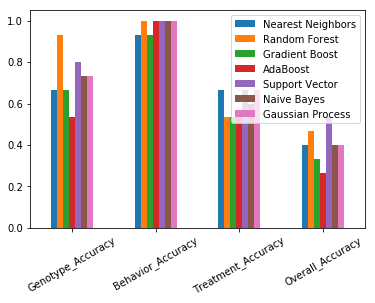

In [17]:
_ = accuracy_df.transpose().plot(kind = 'bar', rot = 30)

In [18]:
importance_df_rf = pd.DataFrame({'protein': X_columns.columns, 
                              'importance': classifier_rf.feature_importances_})
importance_df_rf.sort_values('importance', ascending = False).head(10)

,protein,importance
32,SOD1_N,0.044317
34,P38_N,0.038222
1,ITSN1_N,0.034129
30,APP_N,0.033429
75,CaNA_N,0.032876
10,pERK_N,0.031568
53,ARC_N_pS6_N,0.029067
64,SNCA_N,0.027030
4,NR2A_N,0.024273
19,AKT_N,0.023097


In [19]:
importance_df_rf.to_csv('FeatureImportances_RandomForest_ScaledData.csv')

In [20]:
AOV_results = pd.read_excel('AOV_Results.xls')
AOV_results.rename(columns = {'Unnamed: 0': 'protein'}, inplace = True)
AOV_results.head()

,protein,Genotype,Behavior,Treatment,Geno_Behav,Geno_Treat,Behav_Treat,Triple_Interact
0,DYRK1A_N,0.304586,0.000003,0.774242,0.857949,0.342902,0.919356,0.265457
1,ITSN1_N,0.047022,0.000002,0.624386,0.621065,0.345508,0.630078,0.496069
2,BDNF_N,0.618384,0.099631,0.429408,0.002321,0.389302,0.327711,0.813493
3,NR1_N,0.166782,0.874955,0.438595,0.022318,0.047052,0.569267,0.129409
4,NR2A_N,0.035438,0.159855,0.875950,0.001493,0.073292,0.854869,0.098267


In [21]:
importance_AOV_combine = AOV_results.join(importance_df_rf.set_index('protein'),on = 'protein')
importance_AOV_combine.sort_values('importance',ascending = False).head()

,protein,Genotype,Behavior,Treatment,Geno_Behav,Geno_Treat,Behav_Treat,Triple_Interact,importance
32,SOD1_N,7.011768e-01,2.776359e-18,0.340680,0.369252,0.018835,0.321127,0.014473,0.044317
34,P38_N,7.047535e-03,9.633999e-13,0.001697,0.075958,0.280272,0.873811,0.313384,0.038222
1,ITSN1_N,4.702204e-02,2.433821e-06,0.624386,0.621065,0.345508,0.630078,0.496069,0.034129
30,APP_N,3.084508e-10,3.163029e-02,0.793155,0.022490,0.881944,0.770758,0.533747,0.033429
75,CaNA_N,3.387185e-01,9.359408e-17,0.031853,0.789856,0.463631,0.073963,0.211962,0.032876


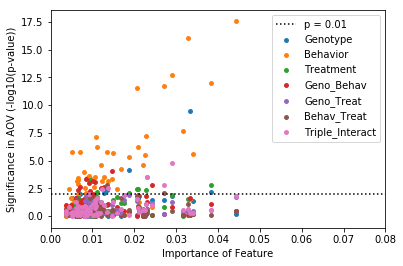

In [22]:
y_columns = importance_AOV_combine.columns[1:-1]
for y_col in y_columns:
    _ = plt.scatter(x = importance_AOV_combine.importance, y = -np.log10(importance_AOV_combine[y_col]), s = 15)
_ = plt.xlabel('Importance of Feature')
_ = plt.ylabel('Significance in AOV (-log10(p-value))')
_ = plt.axhline(-np.log10(0.01), linestyle = ':', color = 'k')
_ = plt.xlim([0,0.08]) #Just putting in a little extra room for the legend
_ = plt.legend(['p = 0.01']+list(y_columns))

In [23]:
pred_df = pd.DataFrame()
for variable in Y.columns[0:3]:
    this_y_train = Y_train[variable]
    classifier = RandomForestClassifier(criterion = 'gini', max_features = 'sqrt', n_estimators = 1000, 
                                        max_depth = None, n_jobs = -1, min_samples_leaf = 1)
    classifier.fit(X_train, this_y_train)
    pred_df[variable] = classifier.predict(X_test)

def interpret_class(genotype, behavior, treatment):
    if (genotype == 'Control'):
        c = 'c-'
    else:
        c = 't-'    
    if (behavior == 'Control'):
        c += 'SC-'
    else:
        c += 'CS-'
    if (treatment == 'Saline'):
        c += 's'
    else:
        c += 'm'
    return c

class_pred = [interpret_class(row[1], row[2], row[3]) for row in pred_df.itertuples()]
print('Accuracy from combining binary predictions is %.2f%%' %(100*np.mean(Y_test['class'] == class_pred)))

Accuracy from combining binary predictions is 40.00%


In [24]:
accuracy_df.loc['Voting'] = divided_score

accuracy_df.loc['RF Binary'] = {'Genotype_Accuracy':  np.mean(pred_df.Genotype == Y_test.reset_index().Genotype), 
                                'Behavior_Accuracy':  np.mean(pred_df.Behavior == Y_test.reset_index().Behavior), 
                                'Treatment_Accuracy': np.mean(pred_df.Treatment == Y_test.reset_index().Treatment), 
                                'Overall_Accuracy':   np.mean(Y_test['class'] == class_pred)}


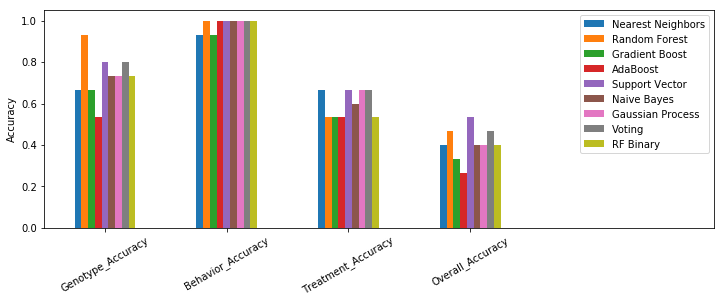

In [27]:
fig, ax = plt.subplots(figsize=(12,4))
_ = accuracy_df.transpose().plot(kind = 'bar', rot = 30, ax=ax)
_ = plt.xlim([-0.5,5])
_ = plt.ylabel('Accuracy')